# A fast velocity computation

## Makes a synthetic set

In [1]:
import MotionClouds as mc
N_X, N_X_up, N_T = 32, 512, 256
fx, fy, ft = mc.get_grids(N_X, N_X_up, 1)
sf_0=0.02
env = mc.envelope_gabor(fx, fy, ft, sf_0=sf_0, B_sf=sf_0, V_X=0., V_Y=0., B_V=0)
x = 2 * mc.rectif(mc.random_cloud(env, seed=1973))[0, :] - 1

In [2]:
mc.envelope_gabor?

Signature:
mc.envelope_gabor(
    fx,
    fy,
    ft,
    V_X=1.0,
    V_Y=0.0,
    B_V=0.5,
    sf_0=0.125,
    B_sf=0.1,
    loggabor=True,
    theta=0.0,
    B_theta=0.19634954084936207,
    alpha=0.0,
    **kwargs,
)
Docstring:
Returns the Motion Cloud kernel, that is the product of:
    * a speed envelope
    * an orientation envelope
    * an orientation envelope
File:      /usr/local/lib/python3.9/site-packages/MotionClouds.py
Type:      function


In [3]:
import numpy as np

In [4]:
def sigmoid(x):
    return 2 / (1 + np.exp(-x)) - 1
slope = 2. 
z = np.tanh(slope*x)

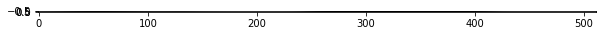

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(z.T, cmap=plt.gray())

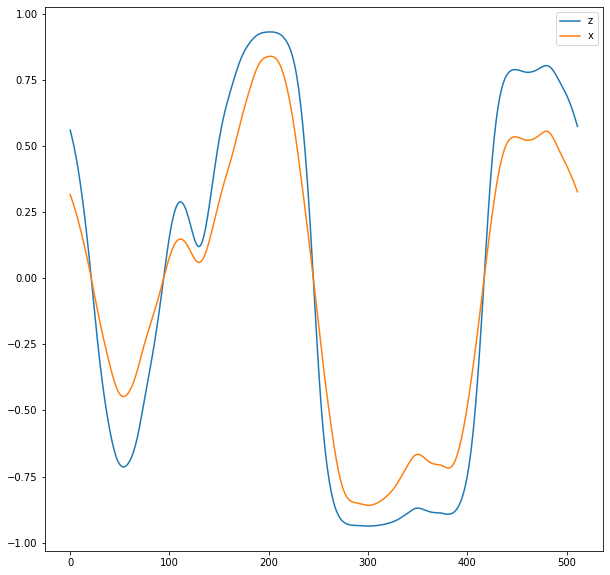

In [6]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.plot(z, label='z')
_ = ax.plot(x, label='x')
plt.legend();

In [7]:
noise = 0.05
I_noise = noise * np.random.randn(N_X, N_T)

In [8]:
up = int(N_X_up/N_X)

In [9]:
I = np.zeros((N_X, N_T))
for i_T in range(N_T):
    I[:, i_T] = np.roll(z, int(i_T*N_X_up/N_T))[::up, 0] 
I += I_noise

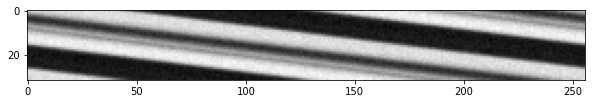

In [10]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(I, cmap=plt.gray())

## transform to events

In [11]:
np.gradient?

Signature: np.gradient(f, *varargs, axis=None, edge_order=1)
Docstring:
Return the gradient of an N-dimensional array.

The gradient is computed using second order accurate central differences
in the interior points and either first or second order accurate one-sides
(forward or backwards) differences at the boundaries.
The returned gradient hence has the same shape as the input array.

Parameters
----------
f : array_like
    An N-dimensional array containing samples of a scalar function.
varargs : list of scalar or array, optional
    Spacing between f values. Default unitary spacing for all dimensions.
    Spacing can be specified using:

    1. single scalar to specify a sample distance for all dimensions.
    2. N scalars to specify a constant sample distance for each dimension.
       i.e. `dx`, `dy`, `dz`, ...
    3. N arrays to specify the coordinates of the values along each
       dimension of F. The length of the array must match the size of
       the corresponding dimensio

In [12]:
print(I.min(), I.max())

-1.1094450173953958 1.0697515233569102


In [13]:
#I[20:40, 40:80] = 0
#Ix = np.gradient(I, axis=0)
It = np.gradient(I, axis=1)

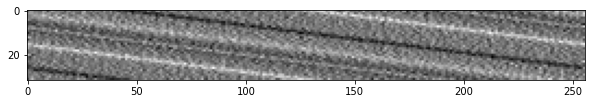

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It, cmap=plt.gray())

In [15]:
print(It.min(), It.max())

-0.1889629937864241 0.21437396567353517


In [16]:
threshold = 0.15

In [17]:
It_ = It.copy()
It_event = np.zeros((N_X, N_T))
for i_T in range(N_T-1):
    It_event[:, i_T] = 1. * (It_[:, i_T] > threshold) - 1. * (It_[:, i_T] < -threshold)
    It_[:, i_T+1] -= threshold * It_event[:, i_T]
#It_event[:, -1] = 0

In [18]:
print(It_event.min(), It_event.max())
print(It_.min(), It_.max())

-1.0 1.0
-0.1889629937864241 0.21437396567353517


In [19]:
np.lookfor('seismic')

Search results for 'seismic'
----------------------------
Nothing found.


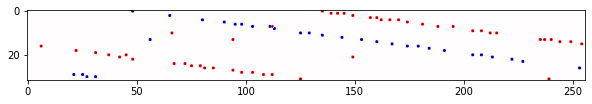

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_event, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [21]:
It_event[:, 0], It_event[:, 10], It_event[:, -1], It_event.shape

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 (32, 256))

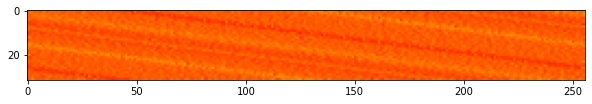

In [22]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_, cmap=plt.hot(), vmin=-1, vmax=1)

## motion compensated transform on events

In [23]:
It_v = np.zeros((N_X, N_T))
V = .5
for i_T in range(N_T):
    It_v[:, i_T] = np.roll(It_event[:, i_T], -int(V*N_X/N_T*i_T))

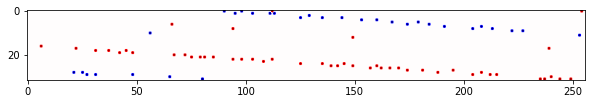

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [25]:
It_v[:, 0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [26]:
p_V_plus = np.sum(It_v==1, axis=1)*1.
p_V_minus = np.sum(It_v==-1, axis=1)*1.

p_V_plus /= np.sum(p_V_plus)
p_V_minus /= np.sum(p_V_minus)

In [27]:
np.sum(p_V_minus)

1.0

(0.0, 0.13548387096774192)

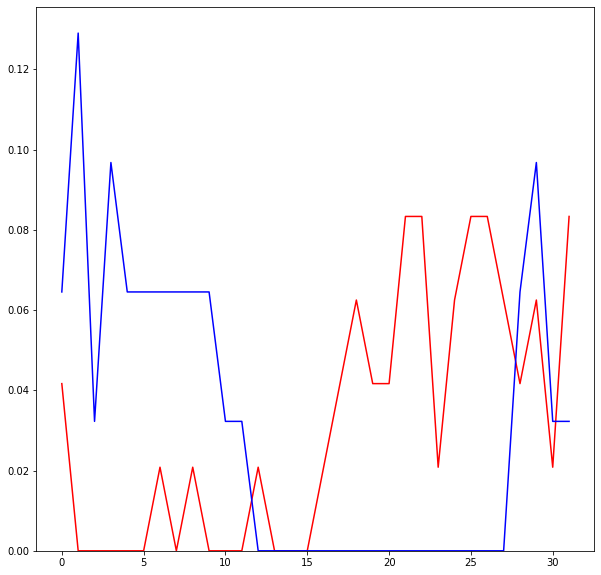

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(p_V_plus, c='r')
ax.plot(p_V_minus, c='b')
ax.set_ylim(0)

In [29]:
entropy = -np.sum( p_V_minus * np.log2(p_V_minus + 1.*(p_V_minus==0)) )
entropy += -np.sum( p_V_plus * np.log2(p_V_plus + 1.*(p_V_plus==0)) )

In [30]:
entropy

8.02029103525053

## transform as an event list

In [31]:
It_v.shape

(32, 256)

In [32]:
import torch

In [33]:
torch.nonzero(torch.Tensor(It_v)).shape, torch.nonzero(torch.Tensor(It_v==1)).shape, torch.nonzero(torch.Tensor(It_v==-1)).shape

(torch.Size([79, 2]), torch.Size([48, 2]), torch.Size([31, 2]))

In [34]:
torch.nonzero(torch.Tensor(It_v))[:10, :]

tensor([[  0,  90],
        [  0,  98],
        [  0, 112],
        [  0, 254],
        [  1,  95],
        [  1, 103],
        [  1, 111],
        [  1, 113],
        [  2, 129],
        [  3, 125]])

x, t, p

In [35]:
events_neg = torch.nonzero(torch.Tensor(It_v==-1))
events_neg.shape, torch.ones(events_neg.shape[0], 1).shape

(torch.Size([31, 2]), torch.Size([31, 1]))

In [36]:
torch.ones(4, 1, dtype=int)

tensor([[1],
        [1],
        [1],
        [1]])

In [37]:
torch.set_default_tensor_type?

Signature: torch.set_default_tensor_type(t)
Docstring:
Sets the default ``torch.Tensor`` type to floating point tensor type
``t``. This type will also be used as default floating point type for
type inference in :func:`torch.tensor`.

The default floating point tensor type is initially ``torch.FloatTensor``.

Args:
    t (type or string): the floating point tensor type or its name

Example::

    >>> torch.tensor([1.2, 3]).dtype    # initial default for floating point is torch.float32
    torch.float32
    >>> torch.set_default_tensor_type(torch.DoubleTensor)
    >>> torch.tensor([1.2, 3]).dtype    # a new floating point tensor
    torch.float64
File:      /usr/local/lib/python3.9/site-packages/torch/__init__.py
Type:      function


In [38]:
events_neg = torch.hstack((events_neg, -1 * torch.ones(events_neg.shape[0], 1, dtype=int)))
events_neg.shape

torch.Size([31, 3])

In [39]:
events_pos = torch.nonzero(torch.Tensor(It_v==1))
events_pos = torch.hstack((events_pos, torch.ones(events_pos.shape[0], 1, dtype=int)))
events_pos.shape

torch.Size([48, 3])

In [40]:
events = torch.vstack((events_pos, events_neg))
events.shape

torch.Size([79, 3])

In [41]:
events[:10, :]

tensor([[  0, 112,   1],
        [  0, 254,   1],
        [  6,  66,   1],
        [  8,  94,   1],
        [ 12, 149,   1],
        [ 16,   6,   1],
        [ 17,  22,   1],
        [ 17, 239,   1],
        [ 18,  31,   1],
        [ 18,  37,   1]])

In [42]:
times, indices = torch.sort(events[:, 1])
events = events[indices, :]

In [43]:
# x, t, p
events[:10, :]

tensor([[16,  6,  1],
        [28, 21, -1],
        [17, 22,  1],
        [28, 25, -1],
        [29, 27, -1],
        [29, 31, -1],
        [18, 31,  1],
        [18, 37,  1],
        [19, 42,  1],
        [18, 45,  1]])

Visual check

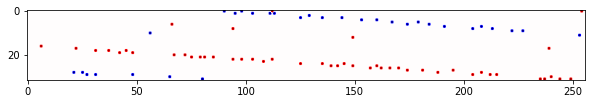

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v, cmap=plt.cm.seismic, vmin=-1, vmax=1)

In [45]:
It_v_ = torch.zeros((N_X, N_T))
It_v_[events[:, 0], events[:, 1]] = 1. * events[:, 2]

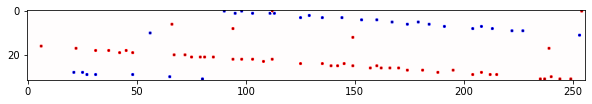

In [46]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

## construction of a constraint

In [47]:
events.shape

torch.Size([79, 3])

In [48]:
torch.fmod?

Docstring:
fmod(input, other, *, out=None) -> Tensor

Applies C++'s `std::fmod <https://en.cppreference.com/w/cpp/numeric/math/fmod>`_
for floating point tensors, and the modulus operation for integer tensors. The result
has the same sign as the dividend :attr:`input` and its absolute value
is less than that of :attr:`other`.

Supports :ref:`broadcasting to a common shape <broadcasting-semantics>`,
:ref:`type promotion <type-promotion-doc>`, and integer and float inputs.

.. note::

    When the divisor is zero, returns ``NaN`` for floating point dtypes
    on both CPU and GPU; raises ``RuntimeError`` for integer division by
    zero on CPU; Integer division by zero on GPU may return any value.

.. note::

   Complex inputs are not supported. In some cases, it is not mathematically
   possible to satisfy the definition of a modulo operation with complex numbers.

Args:
    input (Tensor): the dividend
    other (Tensor or Scalar): the divisor

Keyword args:
    out (Tensor, optional): 

In [49]:
x_ = torch.linspace(-10, N_X+10, 100)
x = torch.remainder(x_, N_X)
N_X, x.min(), x.max()

(32, tensor(0.0202), tensor(31.9798))

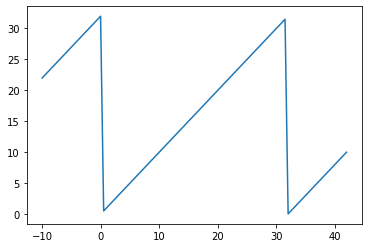

In [50]:
plt.plot(x_, x)

https://en.cppreference.com/w/cpp/numeric/math/fmod

In [51]:
u = 2.
events_u = 1 * events.clone().detach()
events_u[:, 0] = torch.remainder(events[:, 0] - u*N_X/N_T*events[:, 1], N_X)

In [52]:
events_u[:, 0]

tensor([14, 22, 11, 21, 22, 21, 10,  8,  8,  6, 17,  7, 28, 13, 21,  3,  2,  2,
         1, 11,  0, 31,  9, 16, 30,  9, 29,  7, 28,  7, 28,  5,  4, 26,  4,  3,
        24,  1,  1, 22, 22, 21, 31, 19, 19,  6, 29, 18, 28, 17, 17, 16, 27, 15,
        15, 26, 24, 13, 24, 13, 23, 10, 10, 21,  8, 19,  8, 18,  7, 17, 16,  4,
         3, 21,  2,  2,  0, 11,  0])

In [53]:
It_v_ = torch.zeros((N_X, N_T))
It_v_[events_u[:, 0], events_u[:, 1]] = 1. * events_u[:, 2]

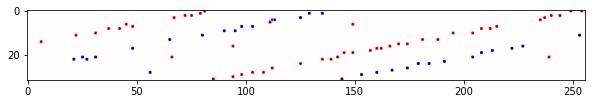

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
_ = ax.imshow(It_v_, cmap=plt.cm.seismic, vmin=-1, vmax=1)

Compute occurences of events in time:


In [55]:
t = events[:, 1]
t, t.shape

(tensor([  6,  21,  22,  25,  27,  31,  31,  37,  42,  45,  48,  48,  56,  65,
          66,  67,  72,  75,  79,  80,  81,  85,  90,  94,  94,  95,  98,  98,
         103, 103, 108, 111, 112, 112, 113, 125, 125, 129, 135, 135, 139, 142,
         144, 145, 149, 149, 153, 157, 160, 160, 162, 166, 167, 170, 174, 174,
         179, 181, 184, 188, 191, 195, 204, 204, 208, 208, 212, 213, 215, 222,
         227, 235, 237, 239, 240, 244, 249, 253, 254]),
 torch.Size([79]))

In [56]:
t[:, None] == t[None, :]

tensor([[ True, False, False,  ..., False, False, False],
        [False,  True, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ...,  True, False, False],
        [False, False, False,  ..., False,  True, False],
        [False, False, False,  ..., False, False,  True]])

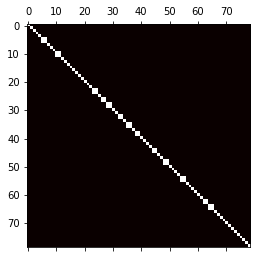

In [57]:
plt.matshow(t[:, None] == t[None, :]);

In [58]:
Ptp = 1. * (t[:, None] == t[None, :]).sum(axis=1)
Ptp /= Ptp.sum()
Ptp, Ptp.shape

(tensor([0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0190, 0.0190, 0.0095, 0.0095,
         0.0095, 0.0190, 0.0190, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
         0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0190, 0.0190, 0.0095, 0.0190,
         0.0190, 0.0190, 0.0190, 0.0095, 0.0095, 0.0190, 0.0190, 0.0095, 0.0190,
         0.0190, 0.0095, 0.0190, 0.0190, 0.0095, 0.0095, 0.0095, 0.0095, 0.0190,
         0.0190, 0.0095, 0.0095, 0.0190, 0.0190, 0.0095, 0.0095, 0.0095, 0.0095,
         0.0190, 0.0190, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0190,
         0.0190, 0.0190, 0.0190, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095,
         0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095, 0.0095]),
 torch.Size([79]))

Compute occurences of events in space:


In [59]:
x = events_u[:, 0]
x, x.shape

(tensor([14, 22, 11, 21, 22, 21, 10,  8,  8,  6, 17,  7, 28, 13, 21,  3,  2,  2,
          1, 11,  0, 31,  9, 16, 30,  9, 29,  7, 28,  7, 28,  5,  4, 26,  4,  3,
         24,  1,  1, 22, 22, 21, 31, 19, 19,  6, 29, 18, 28, 17, 17, 16, 27, 15,
         15, 26, 24, 13, 24, 13, 23, 10, 10, 21,  8, 19,  8, 18,  7, 17, 16,  4,
          3, 21,  2,  2,  0, 11,  0]),
 torch.Size([79]))

In [60]:
sigma = .7
d = np.exp(-(x[:, None] - x[None, :])**2/2/sigma**2)

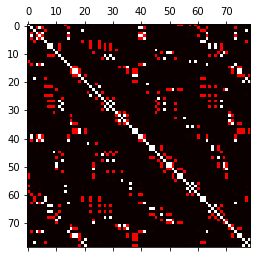

In [61]:
plt.matshow(d);

In [62]:
Pxp = 1. * (x[:, None] == x[None, :]).sum(axis=1)
Pxp /= Pxp.sum()
Pxp, Pxp.shape

(tensor([0.0039, 0.0157, 0.0118, 0.0235, 0.0157, 0.0235, 0.0118, 0.0157, 0.0157,
         0.0078, 0.0157, 0.0157, 0.0157, 0.0118, 0.0235, 0.0118, 0.0157, 0.0157,
         0.0118, 0.0118, 0.0118, 0.0078, 0.0078, 0.0118, 0.0039, 0.0078, 0.0078,
         0.0157, 0.0157, 0.0157, 0.0157, 0.0039, 0.0118, 0.0078, 0.0118, 0.0118,
         0.0118, 0.0118, 0.0118, 0.0157, 0.0157, 0.0235, 0.0078, 0.0118, 0.0118,
         0.0078, 0.0078, 0.0078, 0.0157, 0.0157, 0.0157, 0.0118, 0.0039, 0.0078,
         0.0078, 0.0078, 0.0118, 0.0118, 0.0118, 0.0118, 0.0039, 0.0118, 0.0118,
         0.0235, 0.0157, 0.0118, 0.0157, 0.0078, 0.0157, 0.0157, 0.0118, 0.0118,
         0.0118, 0.0235, 0.0157, 0.0157, 0.0118, 0.0118, 0.0118]),
 torch.Size([79]))

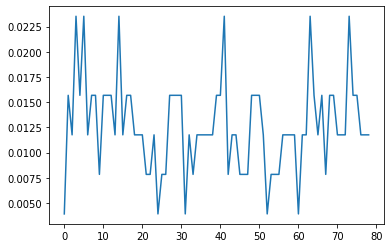

In [63]:
plt.plot(Pxp);

## gradient descent optimization

In [64]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
# https://pytorch.org/docs/master/generated/torch.nn.BCELoss.html
criterion = torch.nn.BCELoss(reduction="sum")

class EMD(torch.nn.Module):
    def __init__(self, u=-20.):
        super(EMD, self).__init__()
        #self.linear = torch.nn.Linear(1, 1, bias=bias)
        self.u = torch.nn.Parameter(u * torch.ones(1), requires_grad=True)

    def forward(self, events):
        It_v = self.u * It_event #torch.zeros_like(It_event)
        #for i_T in range(N_T):
        #    It_v[:, i_T] = torch.roll(It_event[:, i_T], -int(self.u*N_X/N_T*i_T))

        p_V_plus = torch.sum(It_v, axis=1)*1.
        p_V_minus = torch.sum(It_v==-1, axis=1)*1.

        p_V_plus /= torch.sum(p_V_plus)
        p_V_minus /= torch.sum(p_V_minus)
        
        return p_V_plus#, p_V_minus

In [65]:
m = torch.nn.Sigmoid()
criterion = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
loss = criterion(m(input), target)
loss.backward()

In [66]:
loss, target

(tensor(0.8730, grad_fn=<BinaryCrossEntropyBackward0>), tensor([1., 0., 1.]))

In [67]:
torch.empty(3), torch.empty(3).random_(2), torch.empty(3).random_(1)

(tensor([ -2.3158e+77, -1.4946e-154,  -2.3158e+77]),
 tensor([0., 0., 0.]),
 tensor([0., 0., 0.]))

In [68]:
torch.Tensor.random_?

Docstring:
random_(from=0, to=None, *, generator=None) -> Tensor

Fills :attr:`self` tensor with numbers sampled from the discrete uniform
distribution over ``[from, to - 1]``. If not specified, the values are usually
only bounded by :attr:`self` tensor's data type. However, for floating point
types, if unspecified, range will be ``[0, 2^mantissa]`` to ensure that every
value is representable. For example, `torch.tensor(1, dtype=torch.double).random_()`
will be uniform in ``[0, 2^53]``.
Type:      method_descriptor


In [69]:
N_X, N_T = It_event.shape
P_uniform = torch.ones(N_X) / N_X
It_event_ = torch.Tensor(It_event)
print(P_uniform, It_event_.shape)

tensor([0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312, 0.0312,
        0.0312, 0.0312, 0.0312, 0.0312, 0.0312]) torch.Size([32, 256])


In [70]:
emd = EMD()
emd.train()
It_event_ = torch.Tensor(It_event)
out = emd(It_event_)
out

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
p_V_plus, p_V_minus = emd(It_event_)
print(p_V_plus, p_V_minus)

In [ ]:
criterion(p_V_plus, P_uniform), criterion(p_V_minus, P_uniform)

In [ ]:
emd.u

In [ ]:
p_V_plus, p_V_minus = emd(It_event_)
p_V_plus

In [ ]:
emd.u = torch.nn.Parameter(-1 * torch.ones(1))
emd.u.requires_grad = True
p_V_plus, p_V_minus = emd(It_event_)
loss = criterion(p_V_plus, P_uniform) + criterion(p_V_minus, P_uniform)
loss

In [ ]:
p_V_plus.shape, P_uniform.shape

In [ ]:
m = torch.nn.Sigmoid()
loss = torch.nn.BCELoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
output = loss(p_V_plus, P_uniform)

In [ ]:
loss.backward()

In [ ]:
optimizer.step()
losses.append(loss.item())

In [ ]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256

def fit_data(It_event, learning_rate=learning_rate, 
             num_epochs=num_epochs, betas=betas, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_X, N_T = It_event.shape
    P_uniform = torch.ones(N_X) / N_X
    entropy = criterion(P_uniform, P_uniform)
    
    It_event_ = torch.Tensor(It_event)
    It_event_ = It_event_.to(device)
        
    emd = EMD()
    emd = emd.to(device)
    emd.train()
    
    optimizer = torch.optim.Adam(emd.parameters(), lr=learning_rate, betas=betas)
    
    for epoch in range(int(num_epochs)):
        losses = []
        p_V_plus, p_V_minus = emd(It_event_)
        
        loss = criterion(p_V_plus, P_uniform)
        loss += criterion(p_V_minus, P_uniform)
        print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(theta):.5f}")

    return emd, loss

emd, loss = fit_data(It_event, verbose=True)

In [ ]:
emd = EMD()
#emd = emd.to(device)
emd.train()

In [ ]:
emd.u

In [ ]:
for p in emd.parameters():
    print(p)

In [ ]:
kl_loss?

In [ ]:
import torch.nn.functional as F
from torch import nn
kl_loss = nn.KLDivLoss(reduction="batchmean")
# input should be a distribution in the log space
input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# Sample a batch of distributions. Usually this would come from the dataset
target = F.softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, target)

In [ ]:
output

In [ ]:
p, q = F.softmax(torch.rand(30, 5), dim=1), F.softmax(torch.rand(30, 5), dim=1)
log_p, log_q = torch.log(p), torch.log(q)
kl_loss(log_p, q), kl_loss(log_q, p), kl_loss(log_q, q), kl_loss(log_p, p)

In [ ]:
p = torch.rand(30, 5)
q = torch.rand(30, 5)
log_q = torch.log(q)
log_p, log_q = torch.log(p), torch.log(q)
kl_loss(log_p, q), kl_loss(log_q, p), kl_loss(log_q, q), kl_loss(log_p, p)

In [ ]:
q[:10, 0] = .001
log_q = torch.log(q)
kl_loss(log_p, q), kl_loss(log_q, p), kl_loss(log_q, q), kl_loss(log_p, p)

In [ ]:
log_p = F.log_softmax(torch.rand(30, 5), dim=1)
kl_loss(log_p, q), kl_loss(log_q, q), kl_loss(log_p, p)

In [ ]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

In [ ]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

In [ ]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.randn(3, 5), dim=1))

In [ ]:
kl_loss(F.log_softmax(torch.randn(3, 5), dim=1), F.softmax(torch.rand(3, 5), dim=1))

In [ ]:
kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
log_target = F.log_softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, log_target)

In [ ]:
output